In [22]:
import numpy as np
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.reshape(len(X_train), 28 * 28) / 255.0
X_test  = X_test.reshape(len(X_test), 28 * 28) / 255.0

In [23]:
def one_hot(y, num_classes=10):
  Y = np.zeros((len(y), num_classes))
  Y[np.arange(len(y)), y] = 1
  return Y

Y_train = one_hot(y_train, 10)
Y_test  = one_hot(y_test, 10)

In [24]:
class NeuralNet:
  def __init__(self, sizes, activation, w_init, w_decay):
    self.sizes = sizes
    self.w_init = w_init
    self.activation = activation
    self.w_decay = w_decay

    self.weights = []
    self.biases = []

    for i in range(1, len(sizes)):
        if self.w_init == "random":
            W = np.random.randn(sizes[i-1], sizes[i]) * 0.1
        elif self.w_init == "xavier":
            std = np.sqrt(2 / (sizes[i-1] + sizes[i]))
            W = np.random.randn(sizes[i-1], sizes[i]) * std
        b = np.zeros((1, sizes[i]))
        self.weights.append(W)
        self.biases.append(b)

    self.m_W = []
    self.m_B = []
    self.v_W = []
    self.v_B = []
    self.beta = 0.9
    self.beta2 = 0.999

    for i in range(len(self.weights)):
        self.m_W.append(np.zeros_like(self.weights[i]))
        self.m_B.append(np.zeros_like(self.biases[i]))
        self.v_W.append(np.zeros_like(self.weights[i]))
        self.v_B.append(np.zeros_like(self.biases[i]))

    self.a_count = 0
    self.t = 0

  def softmax(self, inputs):
    exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return probabilities

  def relu(self, Z):
    return np.maximum(0, Z)

  def tanh(self, Z):
    return np.tanh(Z)

  def sigmoid(self, Z):
    return 1 / (1 + np.exp(-Z))

  def relu_derivative(self, Z):
    return (Z > 0).astype(float)

  def tanh_derivative(self, Z):
    return 1 - np.tanh(Z) ** 2

  def sigmoid_derivative(self, Z):
    s = 1 / (1 + np.exp(-Z))
    return s * (1 - s)

  def forward(self, X):
    self.A = [X]
    self.Z = []

    A = X
    L = len(self.weights)

    for i in range(L):
      Z = np.dot(A, self.weights[i]) + self.biases[i]
      self.Z.append(Z)

      if i == L - 1:
        A = self.softmax(Z)
      else:
        if self.activation == "relu":
            A = self.relu(Z)
        elif self.activation == "tanh":
            A = self.tanh(Z)
        elif self.activation == "sigmoid":
            A = self.sigmoid(Z)

      self.A.append(A)

    return A

  def loss(self, Y_true, Y_pred):
    Y_pred = np.clip(Y_pred, 1e-7, 1 - 1e-7)
    return -np.sum(Y_true * np.log(Y_pred), axis=1)

  def loss_batches(self, X, Y, batch_size):
    total_samples = X.shape[0]
    total_loss = 0.0

    for i in range(0, total_samples, batch_size):
      Xb = X[i:i + batch_size]
      Yb = Y[i:i + batch_size]
      probs = self.forward(Xb)
      total_loss += np.sum(self.loss(Yb, probs))

    return total_loss / total_samples

  def accuracy(self, X, Y, batch_size):
    total_samples = X.shape[0]
    correct = 0

    for i in range(0, total_samples, batch_size):
      X_batch = X[i:i + batch_size]
      Y_batch = Y[i:i + batch_size]
      probs = self.forward(X_batch)
      y_true = np.argmax(Y_batch, axis=1)
      y_pred = np.argmax(probs, axis=1)
      correct += np.sum(y_true == y_pred)

    return correct / total_samples

  def backward(self, Y_true):
    total_samples = Y_true.shape[0]
    L = len(self.weights)

    self.dW = [0] * L
    self.db = [0] * L

    dZ = self.A[L] - Y_true

    for i in range(L - 1, -1, -1):
      A_prev = self.A[i]
      self.dW[i] = np.dot(A_prev.T, dZ) / total_samples
      self.dW[i] += self.w_decay * self.weights[i]
      self.db[i] = np.sum(dZ, axis=0, keepdims=True) / total_samples

      if i > 0:
        dA_prev = np.dot(dZ, self.weights[i].T)

        if self.activation == "relu":
          grad = self.relu_derivative(self.Z[i - 1])
        elif self.activation == "tanh":
          grad = self.tanh_derivative(self.Z[i - 1])
        elif self.activation == "sigmoid":
          grad = self.sigmoid_derivative(self.Z[i - 1])

        dZ = dA_prev * grad

  def sgd_step(self, lr):
    for i in range(len(self.weights)):
      self.weights[i] -= lr * self.dW[i]
      self.biases[i]  -= lr * self.db[i]

  def momentum(self, lr):
    for i in range(len(self.weights)):
      self.m_W[i] = self.beta * self.m_W[i] + (1 - self.beta) * self.dW[i]
      self.m_B[i] = self.beta * self.m_B[i] + (1 - self.beta) * self.db[i]
      self.weights[i] -= lr * self.m_W[i]
      self.biases[i]  -= lr * self.m_B[i]

  def nesterov(self, lr):
    for i in range(len(self.weights)):
      self.m_W[i] = self.beta * self.m_W[i] + (1 - self.beta) * self.dW[i]
      self.m_B[i] = self.beta * self.m_B[i] + (1 - self.beta) * self.db[i]
      self.weights[i] -= lr * (self.beta * self.m_W[i] + (1 - self.beta) * self.dW[i])
      self.biases[i]  -= lr * (self.beta * self.m_B[i] + (1 - self.beta) * self.db[i])

  def rmsprop(self, lr):
    for i in range(len(self.weights)):
      self.v_W[i] = self.beta * self.v_W[i] + (1 - self.beta) * (self.dW[i] ** 2)
      self.v_B[i] = self.beta * self.v_B[i] + (1 - self.beta) * (self.db[i] ** 2)
      self.weights[i] -= lr * self.dW[i] / (np.sqrt(self.v_W[i]) + 1e-8)
      self.biases[i]  -= lr * self.db[i] / (np.sqrt(self.v_B[i]) + 1e-8)

  def adam(self, lr, eps=1e-8):
    self.a_count += 1
    t = self.a_count

    for i in range(len(self.weights)):
      self.m_W[i] = self.beta * self.m_W[i] + (1 - self.beta) * self.dW[i]
      self.m_B[i] = self.beta * self.m_B[i] + (1 - self.beta) * self.db[i]

      self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * (self.dW[i] ** 2)
      self.v_B[i] = self.beta2 * self.v_B[i] + (1 - self.beta2) * (self.db[i] ** 2)

      mW = self.m_W[i] / (1 - self.beta ** t)
      mB = self.m_B[i] / (1 - self.beta ** t)
      vW = self.v_W[i] / (1 - self.beta2 ** t)
      vB = self.v_B[i] / (1 - self.beta2 ** t)

      self.weights[i] -= lr * mW / (np.sqrt(vW) + eps)
      self.biases[i]  -= lr * mB / (np.sqrt(vB) + eps)

  def nadam(self, lr, eps=1e-8):
    self.t += 1
    t = self.t

    for i in range(len(self.weights)):
      self.m_W[i] = self.beta * self.m_W[i] + (1 - self.beta) * self.dW[i]
      self.m_B[i] = self.beta * self.m_B[i] + (1 - self.beta) * self.db[i]

      self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * (self.dW[i] ** 2)
      self.v_B[i] = self.beta2 * self.v_B[i] + (1 - self.beta2) * (self.db[i] ** 2)

      mW = self.m_W[i] / (1 - self.beta ** t)
      mB = self.m_B[i] / (1 - self.beta ** t)
      vW = self.v_W[i] / (1 - self.beta2 ** t)
      vB = self.v_B[i] / (1 - self.beta2 ** t)

      mW2 = self.beta * mW + (1 - self.beta) * self.dW[i] / (1 - self.beta ** t)
      mB2 = self.beta * mB + (1 - self.beta) * self.db[i] / (1 - self.beta ** t)

      self.weights[i] -= lr * mW2 / (np.sqrt(vW) + eps)
      self.biases[i]  -= lr * mB2 / (np.sqrt(vB) + eps)

  def train(self, X_train, Y_train, X_test, Y_test, epochs, batch_size, lr, step):
    total_samples = X_train.shape[0]

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
      idx = np.random.permutation(total_samples)
      X_train = X_train[idx]
      Y_train = Y_train[idx]

      for i in range(0, total_samples, batch_size):
        Xb = X_train[i:i + batch_size]
        Yb = Y_train[i:i + batch_size]

        self.forward(Xb)
        self.backward(Yb)

        if step == "sgd":
          self.sgd_step(lr)
        elif step == "momentum":
          self.momentum(lr)
        elif step == "nesterov":
          self.nesterov(lr)
        elif step == "rmsprop":
          self.rmsprop(lr)
        elif step == "adam":
          self.adam(lr)
        elif step == "nadam":
          self.nadam(lr)

      train_loss = self.loss_batches(X_train, Y_train, batch_size)
      train_acc  = self.accuracy(X_train, Y_train, batch_size)
      test_loss  = self.loss_batches(X_test, Y_test, batch_size)
      test_acc   = self.accuracy(X_test, Y_test, batch_size)

      train_losses.append(train_loss)
      train_accs.append(train_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

      print("Completed", epoch + 1, "out of", epochs, "epochs")
    return test_acc

Completed 1 out of 5 epochs
Completed 2 out of 5 epochs
Completed 3 out of 5 epochs
Completed 4 out of 5 epochs
Completed 5 out of 5 epochs
Accuracy on the test set of fashion_mnist: 0.8657


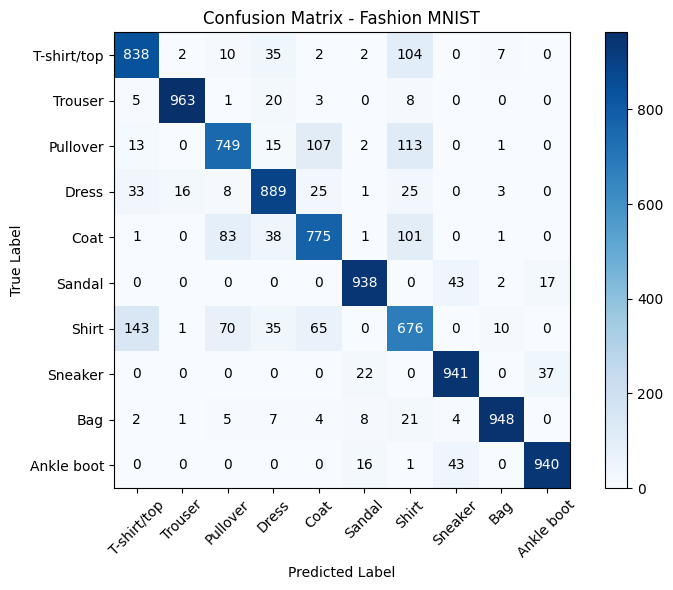

In [29]:
sizes = [784, 128, 128, 128, 128, 128, 10]
activation = "tanh"
weight_initialisation = "random"
weight_decay = 0.0005
model = NeuralNet(sizes, activation, weight_initialisation, weight_decay)

batch_size = 32
lr = 0.0001
epochs = 5
step = "adam"

test_acc = model.train(X_train, Y_train, X_test, Y_test, epochs, batch_size, lr, step)
print("Accuracy on the test set of fashion_mnist:", test_acc)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

probs = model.forward(X_test)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

c_m = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(c_m, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Fashion MNIST")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = c_m.max() / 2.0
for i in range(c_m.shape[0]):
  for j in range(c_m.shape[1]):
    plt.text(
      j, i, c_m[i, j],
      ha="center", va="center",
      color="white" if c_m[i, j] > thresh else "black"
    )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()